# ⚡ XGBoost Models for Drug Sensitivity Prediction

This notebook trains an **XGBoost regression model per drug** using gene expression features. XGBoost is widely used for structured data due to its speed, regularization, and strong predictive performance. We use **5-fold cross-validation** to evaluate model generalization with both RMSE and R² scores.


In [1]:
import os
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.metrics import r2_score, root_mean_squared_error
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Parameters
NUM_PCS = 30
DATA_PATH = "../../../data/processed/gdsc_pancancer_embeddings_30_pcs_tissue_growth.parquet"
data = pd.read_parquet(DATA_PATH)
print("✅ Dataset loaded:", data.shape)

# Setup
os.makedirs("results/xgboost", exist_ok=True)
non_features = ["SANGER_MODEL_ID", "DRUG_ID", "LN_IC50"]
gene_cols = [col for col in data.columns if col not in non_features]
kf = KFold(n_splits=10, shuffle=True, random_state=42)

results = []

✅ Dataset loaded: (83624, 45)


### 🔁 Train One XGBoost Model Per Drug

For each drug, we train a separate XGBoost regressor using its associated (cell line, IC50, features) data. Performance is evaluated using RMSE and R².


In [3]:
# Main loop with clean progress prints
for idx, drug_id in enumerate(sorted(data["DRUG_ID"].unique()), 1):
    df = data[data["DRUG_ID"] == drug_id].dropna(subset=["LN_IC50"])
    if df.shape[0] < 100:
        print(f"⚠️ Skipped drug {drug_id} (samples: {df.shape[0]})")
        continue

    X = df[gene_cols].values
    y = df["LN_IC50"].values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X).astype("float64")
    y = y.astype("float64")

    model = XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )

    # Cross-validated concatenated predictions
    y_pred = cross_val_predict(model, X_scaled, y, cv=kf, n_jobs=-1, method='predict')

    # Fit on all data for potential downstream feature importance extraction
    model.fit(X_scaled, y)

    # Compute metrics
    r2 = r2_score(y, y_pred)
    pearson_r, p_val = pearsonr(y, y_pred)
    rmse = root_mean_squared_error(y, y_pred)

    # Clean progress print
    print(f"\n🌿 Drug {drug_id} | Samples: {len(df)}")
    print(f"  ➤ Global R²: {r2:.4f}")
    print(f"  ➤ Pearson r: {pearson_r:.4f} (p={p_val:.2e})")
    print(f"  ➤ RMSE: {rmse:.4f}")

    results.append({
        "DRUG_ID": drug_id,
        "n_samples": len(df),
        "r2_global": r2,
        "pearson_r": pearson_r,
        "pearson_pval": p_val,
        "rmse": rmse
    })

⚠️ Skipped drug 1 (samples: 24)
⚠️ Skipped drug 3 (samples: 23)
⚠️ Skipped drug 5 (samples: 26)
⚠️ Skipped drug 6 (samples: 27)
⚠️ Skipped drug 9 (samples: 26)
⚠️ Skipped drug 11 (samples: 26)
⚠️ Skipped drug 17 (samples: 25)
⚠️ Skipped drug 29 (samples: 26)
⚠️ Skipped drug 30 (samples: 26)
⚠️ Skipped drug 32 (samples: 26)
⚠️ Skipped drug 34 (samples: 27)
⚠️ Skipped drug 35 (samples: 27)
⚠️ Skipped drug 37 (samples: 27)
⚠️ Skipped drug 38 (samples: 27)
⚠️ Skipped drug 41 (samples: 26)
⚠️ Skipped drug 45 (samples: 26)
⚠️ Skipped drug 51 (samples: 26)
⚠️ Skipped drug 52 (samples: 26)
⚠️ Skipped drug 53 (samples: 26)
⚠️ Skipped drug 54 (samples: 26)
⚠️ Skipped drug 55 (samples: 26)
⚠️ Skipped drug 56 (samples: 26)
⚠️ Skipped drug 59 (samples: 26)
⚠️ Skipped drug 60 (samples: 25)
⚠️ Skipped drug 62 (samples: 26)
⚠️ Skipped drug 63 (samples: 26)
⚠️ Skipped drug 64 (samples: 26)
⚠️ Skipped drug 71 (samples: 26)
⚠️ Skipped drug 83 (samples: 26)
⚠️ Skipped drug 86 (samples: 26)
⚠️ Skipped drug

In [4]:
# Results dataframe
results_df = pd.DataFrame(results)
results_df.to_csv("results/xgboost/scfoundation_10_fold_embeddings_30_pcs_tissue_growth.csv", index=False)
print("\n📁 Saved results to results/xgboost/xgboost_cv_concatenated_metrics.csv")


📁 Saved results to results/xgboost/xgboost_cv_concatenated_metrics.csv


### 📊 Distribution of XGBoost Model Performance

These plots visualize the RMSE and R² across all drug-specific models trained using XGBoost.


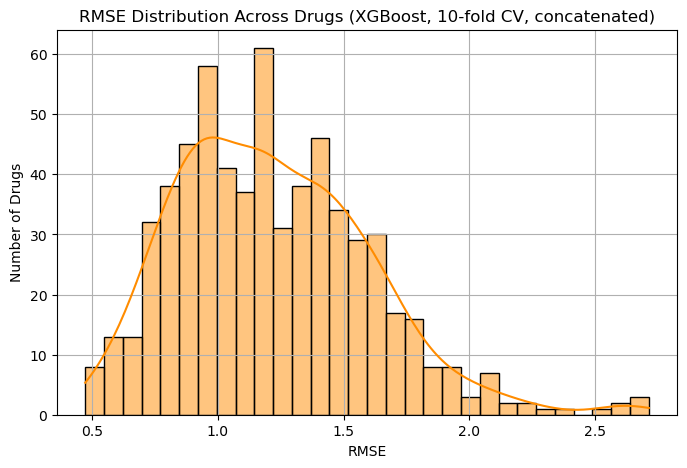

In [5]:
# RMSE Distribution
plt.figure(figsize=(8, 5))
sns.histplot(results_df["rmse"], kde=True, bins=30, color="darkorange")
plt.title("RMSE Distribution Across Drugs (XGBoost, 10-fold CV, concatenated)")
plt.xlabel("RMSE")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()


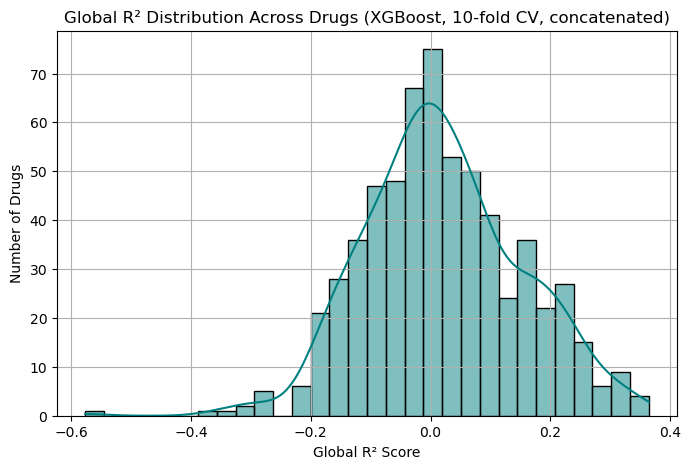

In [6]:
# 📊 Global R² Distribution Across Drugs (XGBoost)
plt.figure(figsize=(8, 5))
sns.histplot(results_df["r2_global"], kde=True, bins=30, color="teal")
plt.title("Global R² Distribution Across Drugs (XGBoost, 10-fold CV, concatenated)")
plt.xlabel("Global R² Score")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()
plt.close()


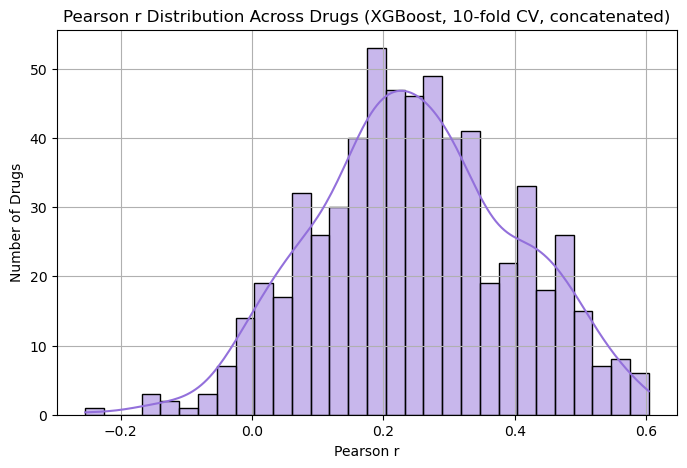

In [7]:
# Pearson r Distribution
plt.figure(figsize=(8, 5))
sns.histplot(results_df["pearson_r"], kde=True, bins=30, color="mediumpurple")
plt.title("Pearson r Distribution Across Drugs (XGBoost, 10-fold CV, concatenated)")
plt.xlabel("Pearson r")
plt.ylabel("Number of Drugs")
plt.grid(True)
plt.show()

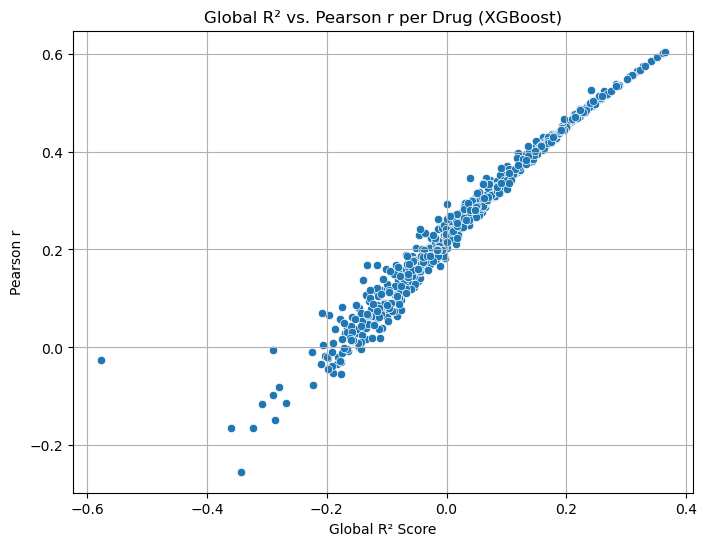

In [8]:
# 📊 Global R² vs. Pearson r consistency plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="r2_global", y="pearson_r")
plt.title("Global R² vs. Pearson r per Drug (XGBoost)")
plt.xlabel("Global R² Score")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()


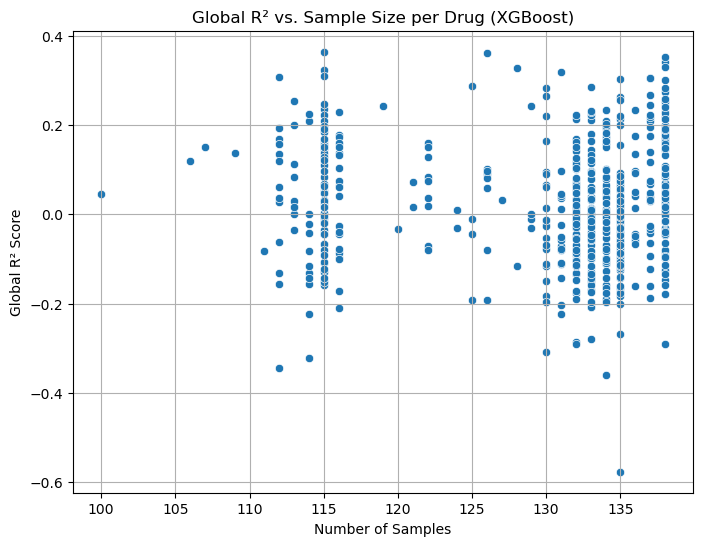

In [9]:
# Scatter: R² vs. Sample Size
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="n_samples", y="r2_global")
plt.title("Global R² vs. Sample Size per Drug (XGBoost)")
plt.xlabel("Number of Samples")
plt.ylabel("Global R² Score")
plt.grid(True)
plt.show()

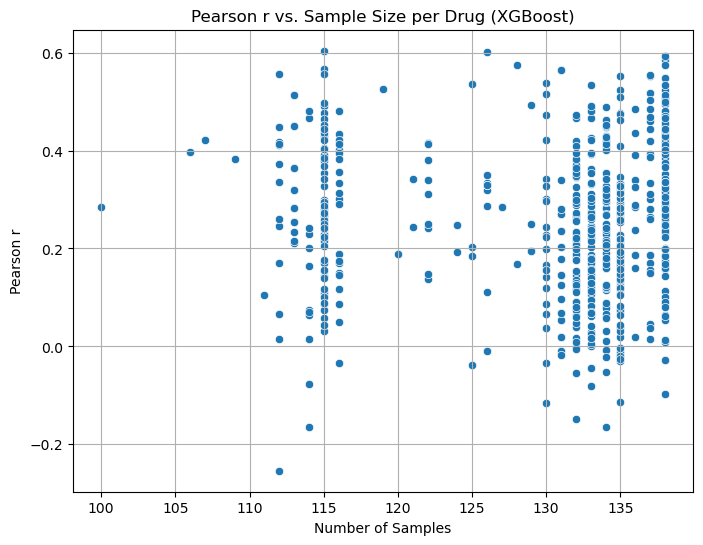

In [10]:
# Scatter: Pearson r vs. Sample Size
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="n_samples", y="pearson_r")
plt.title("Pearson r vs. Sample Size per Drug (XGBoost)")
plt.xlabel("Number of Samples")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()

In [11]:
# Correlations
from scipy.stats import spearmanr

pearson_corr_r2, pval_pearson_r2 = pearsonr(results_df["n_samples"], results_df["r2_global"])
spearman_corr_r2, pval_spearman_r2 = spearmanr(results_df["n_samples"], results_df["r2_global"])
print(f"\n📊 Pearson r (samples vs R²) = {pearson_corr_r2:.3f} (p = {pval_pearson_r2:.3g})")
print(f"📊 Spearman ρ (samples vs R²) = {spearman_corr_r2:.3f} (p = {pval_spearman_r2:.3g})")

pearson_corr_r, pval_pearson_r = pearsonr(results_df["n_samples"], results_df["pearson_r"])
spearman_corr_r, pval_spearman_r = spearmanr(results_df["n_samples"], results_df["pearson_r"])
print(f"📊 Pearson r (samples vs Pearson r) = {pearson_corr_r:.3f} (p = {pval_pearson_r:.3g})")
print(f"📊 Spearman ρ (samples vs Pearson r) = {spearman_corr_r:.3f} (p = {pval_spearman_r:.3g})")



📊 Pearson r (samples vs R²) = -0.026 (p = 0.524)
📊 Spearman ρ (samples vs R²) = 0.058 (p = 0.147)
📊 Pearson r (samples vs Pearson r) = -0.035 (p = 0.38)
📊 Spearman ρ (samples vs Pearson r) = 0.048 (p = 0.233)


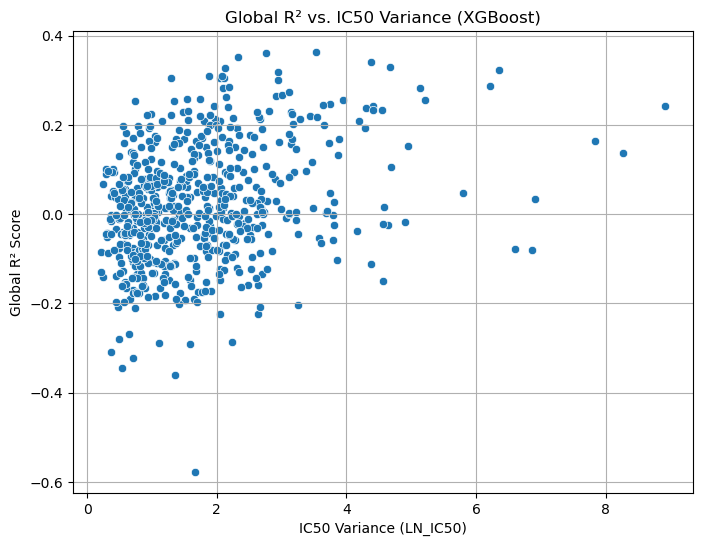

In [12]:
# IC50 variance correlations
variances = data.groupby("DRUG_ID")["LN_IC50"].var()
results_df = results_df.merge(variances.rename("ic50_variance"), on="DRUG_ID")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="ic50_variance", y="r2_global")
plt.title("Global R² vs. IC50 Variance (XGBoost)")
plt.xlabel("IC50 Variance (LN_IC50)")
plt.ylabel("Global R² Score")
plt.grid(True)
plt.show()

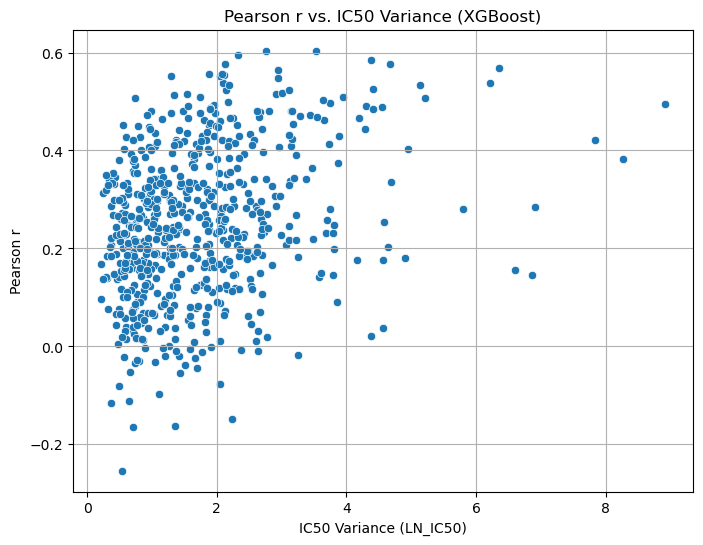

In [13]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=results_df, x="ic50_variance", y="pearson_r")
plt.title("Pearson r vs. IC50 Variance (XGBoost)")
plt.xlabel("IC50 Variance (LN_IC50)")
plt.ylabel("Pearson r")
plt.grid(True)
plt.show()

In [14]:
pearson_corr_var, pval_pearson_var = pearsonr(results_df["ic50_variance"], results_df["pearson_r"])
spearman_corr_var, pval_spearman_var = spearmanr(results_df["ic50_variance"], results_df["pearson_r"])
print(f"📊 Pearson r (IC50 variance vs Pearson r) = {pearson_corr_var:.3f} (p = {pval_pearson_var:.3g})")
print(f"📊 Spearman ρ (IC50 variance vs Pearson r) = {spearman_corr_var:.3f} (p = {pval_spearman_var:.3g})")


📊 Pearson r (IC50 variance vs Pearson r) = 0.304 (p = 8.75e-15)
📊 Spearman ρ (IC50 variance vs Pearson r) = 0.289 (p = 1.59e-13)
